<a href="https://colab.research.google.com/github/HermitCrab07/Impact_of_HbA1c_on_Readmission_Rates/blob/main/_4_Regression_on_Diabetes_Dataset_for_Causal_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

REGRESSION MODELS FITTED BELOW - Question is: What features and/or covariates should we use? There are the standard ones like age, race, and gender (which is not included currently but will be later) as well as the features that are more predictive of not the status at baseline but what happened during the encounter (treatment wise - i.e., markers of what was done to the patient during the encounter)
* SIMPLE LOGISTIC REGRESSION (helps with interpretation of individual regression coefficients)
* SUPPORT VECTOR MACHINES
* RANDOM FOREST
* XGBOOST
* FEATURE IMPORTANCE
* SHAP FOR INTEREPRETATION

---



In [2]:
# Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore
# Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records
# BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.
# Dataset was downloaded from UCI Machine Learning Repository.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Analysis_Diabetes_Dataset_CausalInference/reanalysis_diabetes_dataset.csv')
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,Treatment,Insured,Readmission
count,7.151800e+04,7.151800e+04,71518.000000,71518.000000,71518.000000,71518.00000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000
mean,1.568156e+08,5.505160e+07,2.100254,3.593235,5.657457,4.28913,43.075478,1.430577,15.705025,0.280069,0.103540,0.177829,7.245700,0.215163,0.565941,0.398962
std,1.003769e+08,3.947573e+07,1.508301,5.269771,4.162580,2.94921,19.952338,1.759864,8.311163,1.068957,0.509187,0.603790,1.994674,0.410938,0.495636,0.489688
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,8.145807e+07,2.337577e+07,1.000000,1.000000,1.000000,2.00000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000
50%,1.440574e+08,4.816680e+07,1.000000,1.000000,7.000000,3.00000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.000000,0.000000
75%,2.155513e+08,8.752222e+07,3.000000,3.000000,7.000000,6.00000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000,0.000000,1.000000,1.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.00000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000,1.000000,1.000000,1.000000


In [4]:
# Predict who gets readmitted - LOGISTIC REGRESSION, SVM, RANDOM FOREST, XGBOOST

# I. LOGISTIC REGRESSION

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Covariates used in paper are not helpful to the prediction of readmission - i.e., might show an association with it but no causation
# X_covariates_in_paper = df[['discharge', 'race', 'admission', 'medical_specialty', 'time_in_hospital', 'age', 'diagnoses', 'HbA1c']]

df['Insured_Treatment_int'] = df['Insured'] * df['Treatment']

X_covariates_in_treat = df[['num_procedures', 'number_emergency','num_medications', 'Insured', 'Treatment', 'Insured_Treatment_int']]
y = df['Readmission']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_covariates_in_treat, y, test_size=0.2, random_state=42)

# Create and train a Logistic Regression model
model = LogisticRegression(max_iter = 500)
result = model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print other evaluation metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Print the coefficients along with their corresponding feature names
coefficients = model.coef_  # Get the coefficients from the trained model
print("\nCoefficients:")
for i, feature_name in enumerate(X_train.columns):
    print(f"{feature_name}: {coefficients[0][i]}")

Accuracy: 0.6173797539149888

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.96      0.75      8719
           1       0.57      0.09      0.15      5585

    accuracy                           0.62     14304
   macro avg       0.59      0.52      0.45     14304
weighted avg       0.60      0.62      0.52     14304


Confusion Matrix:
 [[8346  373]
 [5100  485]]

Coefficients:
num_procedures: -0.05407401457312646
number_emergency: 0.40011167304511225
num_medications: 0.013163335292358075
Insured: -0.22642068551686534
Treatment: 0.31303332306306886
Insured_Treatment_int: 0.14179827239001927


In [5]:
import statsmodels.api as sm

# Add a constant term for the intercept
X_covariates_in_treat = sm.add_constant(X_covariates_in_treat)

y = df['Readmission']

# Create and fit the statsmodels logistic regression model
model = sm.Logit(y, X_covariates_in_treat)
results = model.fit()

# Print the summary, which includes p-values
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.663388
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Readmission   No. Observations:                71518
Model:                          Logit   Df Residuals:                    71511
Method:                           MLE   Df Model:                            6
Date:                Tue, 15 Apr 2025   Pseudo R-squ.:                 0.01368
Time:                        20:31:46   Log-Likelihood:                -47444.
converged:                       True   LL-Null:                       -48102.
Covariance Type:            nonrobust   LLR p-value:                3.547e-281
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.5306      0.020    -27.058      0.000      -0.569      -0.

In [6]:
# --- 2. Random Forest ---
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("\nRandom Forest Accuracy:", accuracy_rf)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Get feature importances
importances_rf = model_rf.feature_importances_
feature_names_rf = X_train.columns
# Print feature importances
for i, feature_name in enumerate(feature_names_rf):
    print(f"{feature_name}: {importances_rf[i]}")



Random Forest Accuracy: 0.6087807606263982
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.90      0.74      8719
           1       0.50      0.16      0.24      5585

    accuracy                           0.61     14304
   macro avg       0.56      0.53      0.49     14304
weighted avg       0.57      0.61      0.54     14304

Random Forest Confusion Matrix:
 [[7812  907]
 [4689  896]]
num_procedures: 0.16059798293508037
number_emergency: 0.12711391927184526
num_medications: 0.6020458734416714
Insured: 0.03491519582960838
Treatment: 0.05808275617354818
Insured_Treatment_int: 0.017244272348246478


In [ ]:
!pip install xgboost
!pip install scikit-learn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC  # Import SVM classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_covariates_in_treat, y, test_size=0.2, random_state=42)


# --- 1. SVM ---
model_svm = SVC(random_state=42)  # Create an SVM classifier
model_svm.fit(X_train, y_train)  # Train the SVM model
y_pred_svm = model_svm.predict(X_test)  # Make predictions

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("\nSVM Accuracy:", accuracy_svm)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))



SVM Accuracy: 0.6153523489932886
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.99      0.76      8719
           1       0.63      0.04      0.07      5585

    accuracy                           0.62     14304
   macro avg       0.62      0.51      0.41     14304
weighted avg       0.62      0.62      0.49     14304

SVM Confusion Matrix:
 [[8598  121]
 [5381  204]]


In [9]:
# --- 3. XGBoost ---

model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("\nXGBoost Accuracy:", accuracy_xgb)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# Get feature importances
importances_xgb = model_xgb.feature_importances_
feature_names_xgb = X_train.columns
# Print feature importances
for i, feature_name in enumerate(feature_names_xgb):
    print(f"{feature_name}: {importances_xgb[i]}")


XGBoost Accuracy: 0.6169602908277405
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.90      0.74      8719
           1       0.53      0.17      0.26      5585

    accuracy                           0.62     14304
   macro avg       0.58      0.54      0.50     14304
weighted avg       0.59      0.62      0.55     14304

XGBoost Confusion Matrix:
 [[7881  838]
 [4641  944]]
const: 0.0
num_procedures: 0.08721525967121124
number_emergency: 0.18802452087402344
num_medications: 0.09084959328174591
Insured: 0.14460910856723785
Treatment: 0.4416777491569519
Insured_Treatment_int: 0.04762380197644234


In [10]:
from sklearn.metrics import roc_auc_score

y_train_pred = model_xgb.predict_proba(X_train)[:, 1]
y_test_pred = model_xgb.predict_proba(X_test)[:, 1]

print("Train AUC:", roc_auc_score(y_train, y_train_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))


Train AUC: 0.6094940287676047
Test AUC: 0.585093360048949


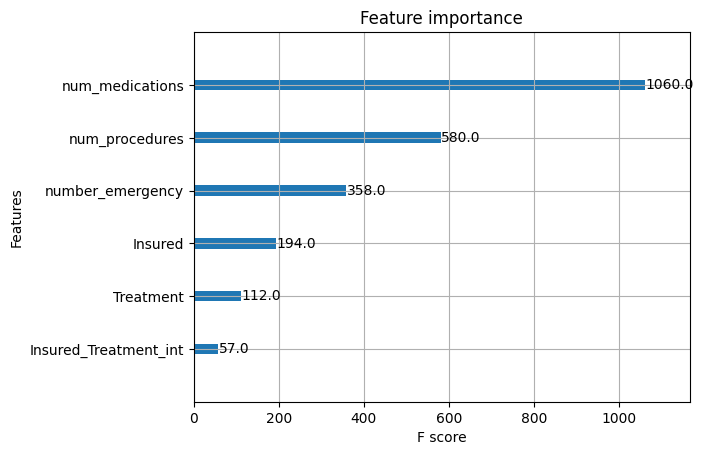

In [11]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model_xgb)
plt.show()


The difference in the way coefficients or importance is represented in XGBoost compared to traditional logistic regression primarily stems from the underlying methodologies and model structures used in each approach. Here's a breakdown of why they might appear different, especially in terms of sign and magnitude, and how to interpret results from XGBoost:

### Differences in Model Structure
1. Logistic Regression:
   - Linear Model in the logit scale: Logistic regression is a linear model where the coefficients represent the log odds of the dependent variable given a one-unit change in the predictor, assuming other predictors are held constant. So easier to interpret.
   - Coefficients: Positive coefficients indicate that as the predictor variable increases, the probability of the target variable being 1 increases. Conversely, a negative coefficient suggests a decrease in the probability with an increase in the predictor.

2. XGBoost:
   - XGBoost builds an ensemble of decision trees, where each tree is built to correct the errors of the previous ones. It does not produce a simple linear formula but rather a set of rules and splits across many trees.
   - Metrics: Instead of coefficients, XGBoost uses scores to indicate the contribution of each feature. The signs of coefficients don't matter here as each tree in the ensemble makes splits that contribute positively/negatively to the final outcome.

Interpretation of XGBoost Outputs
- Feature Importance: Unlike logistic regression where the sign and magnitude of coefficients are directly interpretable, XGBoost provides feature importance scores which tell you how useful or valuable each feature was in the construction of the boosted trees within the model. The importance does not indicate the direction of the association but rather the strength of the relationship, which is counterintuitive if one is mostly used to working with logistic regression.

- SHAP Values: SHapley Additive exPlanations are a way to understand the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

Using XGBoost for Interpretation

- Direct Interpretation: While traditional model coefficients are not available, XGBoost's strength lies in its predictive power and ability to handle various types of data effectively, not necessarily in the interpretability of individual decision paths.
- SHAP for Detailed Insights: For deeper insight into how individual features affect predictions, SHAP is good. SHAP decompose a prediction to show the contribution of EACH feature, which is kind of important else interpretability is really low.
- Prediction Over Interpretation: XGBoost is often used in scenarios where model performance (in terms of prediction accuracy that is) is more critical than the interpretability of individual coefficients.

Conclusion
While logistic regression provides coefficients that are straightforward to interpret under the framework of odds ratios (which is why I love it), XGBoost is a more of a prediction model at the cost of straightforward interpretability (which is why SHAP is necessary).

SHAP is invaluable for extracting meaningful interpretations from models like XGBoost, where they provide detailed explanations for individual predictions, helping to bridge the gap between predictive performance and interpretability.

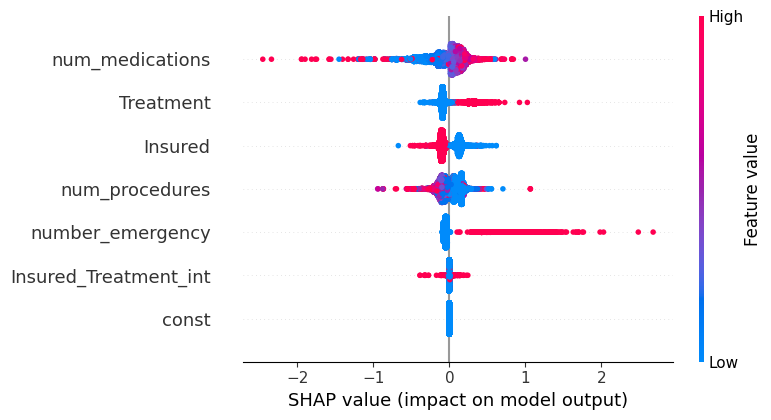

In [12]:
import shap
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)




---



---



The SHAP (SHapley Additive exPlanations) plot gives insights into how features in the model influence the outcome.

- Horizontal Axis (SHAP value): Represents the impact of each feature on the model output. A SHAP value of zero means the feature did not change the prediction from the baseline. Positive values indicate increased likelihood of the positive class (or higher values of the model output), while negative values suggest a decrease.
- Vertical Axis (Features): Each dot represents the SHAP value for an individual observation's feature in the dataset.

Feature Importance/Interpretation
1. num_medications: This has a wide spread of SHAP values, ranging from slightly negative to positive, but most are clustered around zero. So while for most patients, number of medications doesn't significantly impact the model's output, it can be an important factor for certain observations, either increasing or decreasing the predicted value.

2. Treatment: Shows a mix of positive/negative effects but also has a cluster of positive SHAP values. Implication: Treatment increases (yes - increases) the likelihood of the readmission, i.e. the outcome, although it can decrease it for some observations.

3. Insured: Similar to Treatment, the Insured feature shows a positive impact on the model's output, so being insured tends to increase the likelihood of the outcome your model predicts.

4. num_procedures: The number of procedures has a smaller range of values (negative) showing that more procedures generally decrease the predicted outcome, with a few exceptions.

5. number_emergency: This feature shows mostly negative impacts with a compact clustering of SHAP values, suggesting a consistent decrease in the predicted outcome with increasing emergency visits.

6. Insured_Treatment_int: This interaction term has a range of both positive and negative values, though it appears tightly clustered around zero. Interaction between being insured and receiving treatment does NOT affect the outcome, but it can be significant in specific cases. This is strange and contradicts what the cross tabs showed?


Summary
- Treatment and Insured show positive effects, while num_procedures and number_emergency are mostly negative. So both Treatment and Insured are MORE likely to result in Readmission while num_procedures and number_emergency are mostly protective against Readmission.

- The variability in SHAP for num_medications and the interaction term suggests that their impact might be context-dependent or vary significantly across different patients.

- Observations with more bright colors in +SHAP values indicate situations where high features  push the model towards a higher likelihood of readmission, and vice versa.

